In [1]:
import pandas as pd

# Load the dataset
file_path = './autoconf_final_results.csv'
df = pd.read_csv(file_path)

# Group by TEST_SET and find the best configuration for each one based on PERFORMANCE
best_configurations = df.loc[df.groupby('TEST_SET')['PERFORMANCE'].idxmax()]

# Calculate the average PERFORMANCE for each TEST_SET
average_performance = df.groupby('TEST_SET')['PERFORMANCE'].mean().reset_index()

# Save the best configurations and average performance to CSV files
best_configurations.to_csv('best_configurations_per_test_set.csv', index=False)
average_performance.to_csv('average_performance_per_test_set.csv', index=False)

# Display the results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Best Configurations per TEST_SET", dataframe=best_configurations)
# tools.display_dataframe_to_user(name="Average PERFORMANCE per TEST_SET", dataframe=average_performance)

# Print the best configurations and average performance dataframes
print("Best Configurations per TEST_SET:")
# print(best_configurations)
print("\nAverage PERFORMANCE per TEST_SET:")
# print(average_performance)
best_configurations[['TEST_SET', 'REGRESSOR', 'DATASET', 'PERFORMANCE']]

Best Configurations per TEST_SET:

Average PERFORMANCE per TEST_SET:


,TEST_SET,REGRESSOR,DATASET,PERFORMANCE
0,D1,automl_gradient_boosting,all,0.7365
169,D10,LinearRegression,gridsearch,1.0000
41,D2,NN,optuna,0.9992
2,D3,automl_gradient_boosting,all,0.9901
33,D4,NN,all,0.9986
14,D5,automl_extra_trees,optuna,0.9887
15,D6,automl_extra_trees,optuna,0.8333
86,D7,RandomForestRegressor,gridsearch,0.9602
177,D8,SVR,optuna,0.8393
88,D9,RandomForestRegressor,gridsearch,0.9957


# AUC

['tpe' 'random' 'qmc']


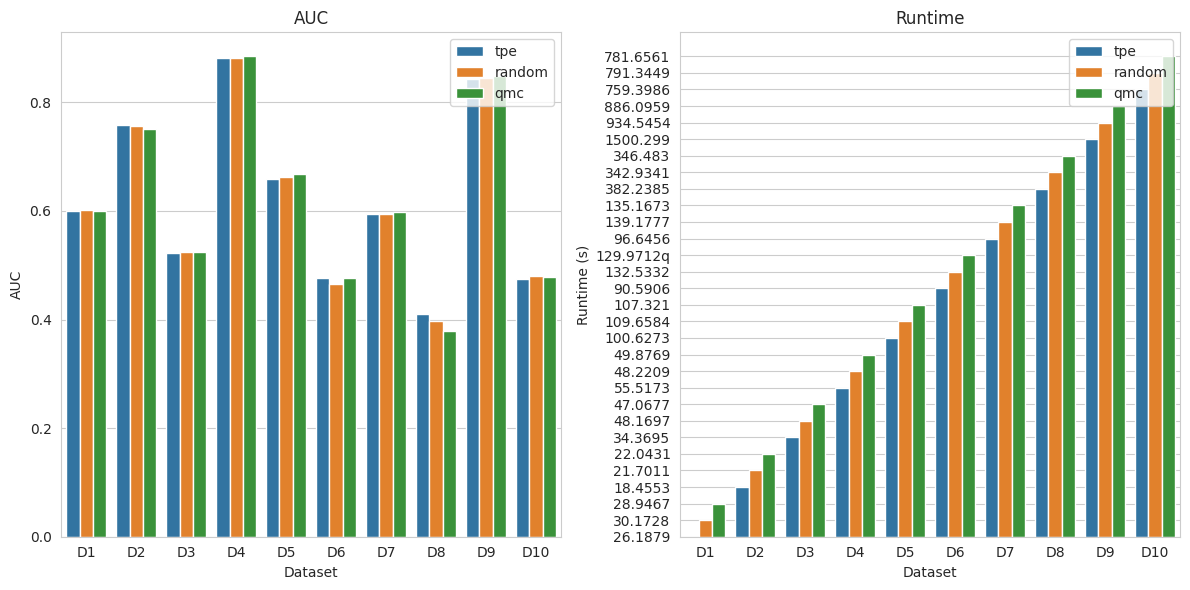

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

df = pd.read_csv("../trials/results/auc.csv")

methods = df['sampler'].unique()
print(methods)

# Set the style of the axes
sns.set_style("whitegrid")

# Create subplots for AUC and Runtime
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plot AUC
sns.barplot(ax=axes[0], x='dataset', y='auc', hue='sampler', data=df)
axes[0].set_title('AUC')
axes[0].set_ylabel('AUC')

# Plot Runtime as line plot
sns.barplot(ax=axes[1], x='dataset', y='runtime', hue='sampler', data=df)

axes[1].set_title('Runtime')
axes[1].invert_yaxis()  # Invert the y-axis for the runtime plot
axes[1].set_ylabel('Runtime (s)')

# Set common labels and adjust the layout
for ax in axes:
    ax.set_xlabel('Dataset')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/auc.png')
plt.show()

# Convergance diagrams

## F1

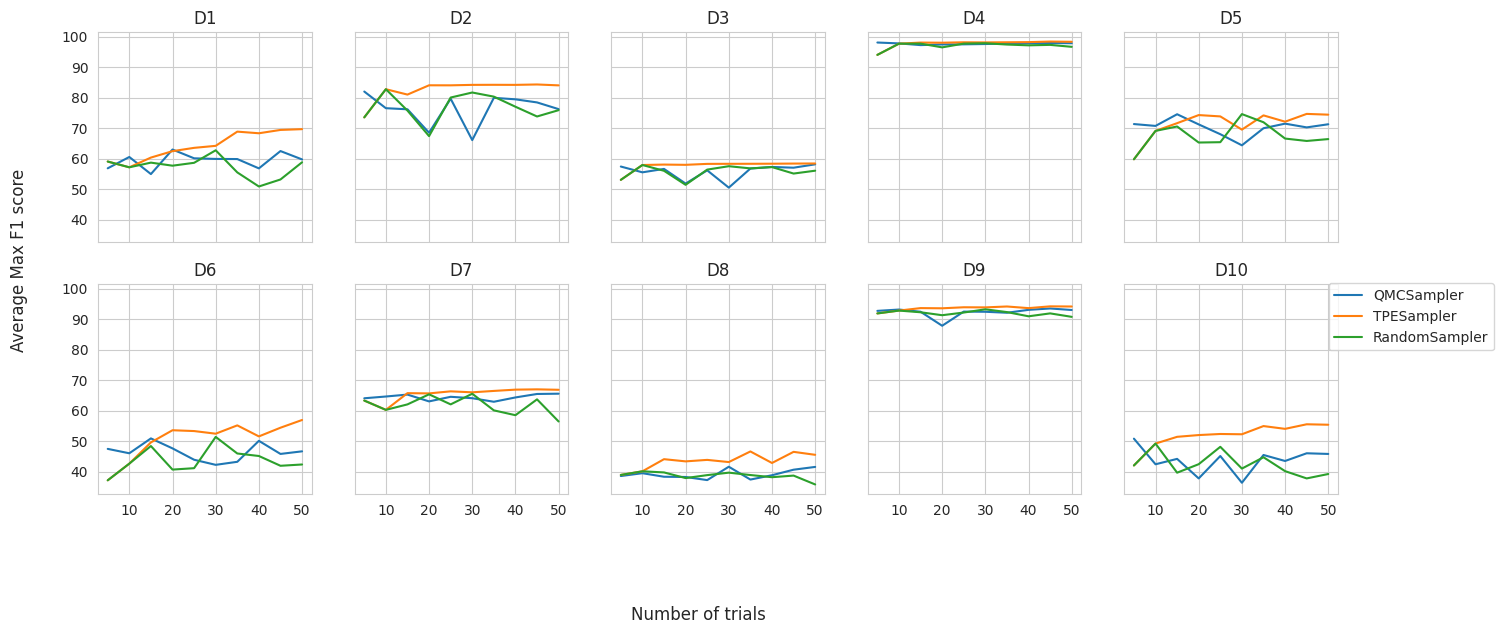

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# set the style of the axes
sns.set_style("whitegrid")

# Directories containing the CSV files
suffix = '../trials/results/'
dirs = ['qmc', 'tpe', 'random']
methods = ['QMCSampler', 'TPESampler', 'RandomSampler']

# Initialize a dictionary to hold dataframes for each dataset
data = {f'D{i}': {method: None for method in methods} for i in range(1, 11)}

# Load the data from each directory
for method, directory in zip(methods, dirs):
    for i in range(1, 11):
        batches = [i for i in range(5, 50 + 5, 5)]
        df = pd.read_csv(f'{suffix}{directory}/D{i}.csv')
        # Sort increasing on seed column
        df = df.sort_values(by=['seed', 'trial'])
        max_trials = []
        seed = df['seed'].iloc[0]
        for row in df.iterrows():
            row = row[1]
            prev_seed = seed
            seed = row['seed']
            if seed != prev_seed:
                batches = [i for i in range(5, 50 + 5, 5)]
            trials_id = row['trial']
            max_trials.append(batches[0])
            if trials_id == batches[0] - 1:
                batches.pop(0)
        df['max_trials'] = max_trials
        data[f'D{i}'][method] = df

# Set up the 2x5 subplots
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

# Function to plot convergence for a given dataset
def plot_convergence(ax, dataset_name, dataset_data):
    for method in methods:
        df = dataset_data[method]
        
        # Calculate the max F1 score for each trial
        max_f1_per_seed_trial = df.groupby(['seed', 'max_trials'])['f1'].max().reset_index()
        
        # Calculate the average max F1 score for each trial across seeds
        avg_max_f1_per_trial = max_f1_per_seed_trial.groupby('max_trials')['f1'].mean().reset_index()
        
        ax.plot(avg_max_f1_per_trial['max_trials'], avg_max_f1_per_trial['f1'], label=method)
    
    ax.set_title(f'{dataset_name}')
    ax.grid(True)

# Generate and save plots for each dataset
for i in range(1, 11):
    dataset_name = f'D{i}'
    ax = axes[i-1]
    plot_convergence(ax, dataset_name, data[dataset_name])

# Set common labels
# fig.text( 'Number of trials', ha='center')
# fig.text( 'Average Max F1 score', va='center', rotation='vertical')
fig.legend(methods, loc='center right', ncol=1) 

# add x and y labels
fig.text(0.5, -0.1, 'Number of trials', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Average Max F1 score', va='center', rotation='vertical', fontsize=12)

# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

# Save the plot
plt.savefig('../figures/f1_convergence_plots.png')

plt.show()


## Runtime

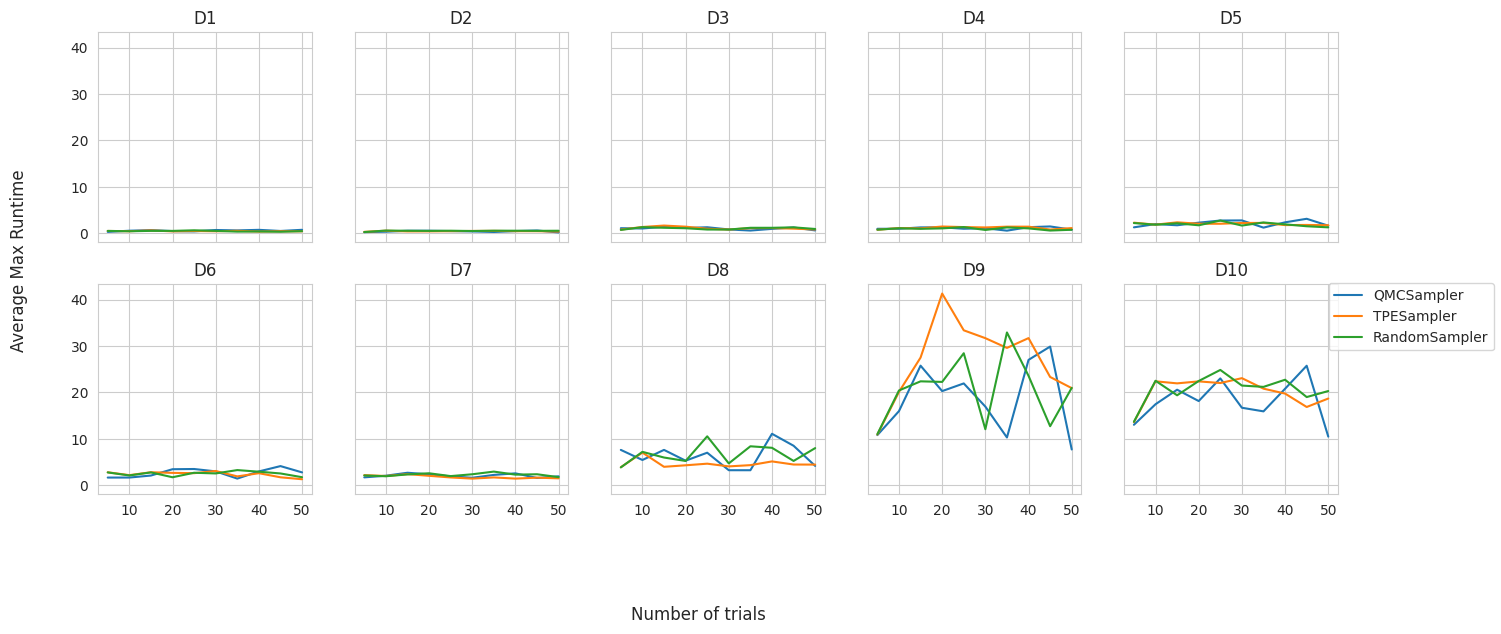

In [53]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the style of the axes
sns.set_style("whitegrid")

# Directories containing the CSV files
suffix = '../trials/results/'
dirs = ['qmc', 'tpe', 'random']
methods = ['QMCSampler', 'TPESampler', 'RandomSampler']

# Initialize a dictionary to hold dataframes for each dataset
data = {f'D{i}': {method: None for method in methods} for i in range(1, 11)}

# Load the data from each directory
for method, directory in zip(methods, dirs):
    for i in range(1, 11):
        batches = [i for i in range(5, 50 + 5, 5)]
        df = pd.read_csv(f'{suffix}{directory}/D{i}.csv')
        # Sort increasing on seed column
        df = df.sort_values(by=['seed', 'trial'])
        max_trials = []
        seed = df['seed'].iloc[0]
        for row in df.iterrows():
            row = row[1]
            prev_seed = seed
            seed = row['seed']
            if seed != prev_seed:
                batches = [i for i in range(5, 50 + 5, 5)]
            trials_id = row['trial']
            max_trials.append(batches[0])
            if trials_id == batches[0] - 1:
                batches.pop(0)
        df['max_trials'] = max_trials
        data[f'D{i}'][method] = df

# Set up the 2x5 subplots
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

def plot_convergence(ax, dataset_name, dataset_data):
    for method in methods:
        df = dataset_data[method]
        
        # Find the row with the best F1 score for each seed and max_trials
        idx = df.groupby(['seed', 'max_trials'])['f1'].idxmax()
        best_f1_runtime_per_seed_trial = df.loc[idx, ['seed', 'max_trials', 'runtime']]
        
        # Calculate the average runtime for the best F1 score across seeds and trials
        avg_runtime_per_trial = best_f1_runtime_per_seed_trial.groupby('max_trials')['runtime'].mean().reset_index()
        
        ax.plot(avg_runtime_per_trial['max_trials'], avg_runtime_per_trial['runtime'], label=method)
    
    ax.set_title(f'{dataset_name}')
    ax.grid(True)

# Generate and save plots for each dataset
for i in range(1, 11):
    dataset_name = f'D{i}'
    ax = axes[i-1]
    plot_convergence(ax, dataset_name, data[dataset_name])

# Set common labels
fig.text(0.5, -0.1, 'Number of trials', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Average Max Runtime', va='center', rotation='vertical', fontsize=12)

fig.legend(methods, loc='center right', ncol=1)

# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# Save the plot
plt.savefig('../figures/runtime_convergence_plots.png')
plt.show()
